## Homework №3

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
from datetime import datetime

DEVICE_NAME = 'cuda:0'

now = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
model_name = f'gru_attention_beam_search_{now}'

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_to_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_to_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_to_data = './data.txt'

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import torchtext
from torchtext.data import Field, BucketIterator
from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from tqdm import tqdm
import time
import random

import matplotlib.pyplot as plt
%matplotlib inline

from utils import generate_translation, remove_tech_tokens, get_text, \
                    parse_tensorboard_logs, plot_metrics, beam_search, _len_sort_key, init_weights, count_parameters

In [4]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [5]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [6]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_to_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [7]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05], random_state=random.seed(SEED))

In [8]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [9]:
SRC.build_vocab(train_data, min_freq=3)
TRG.build_vocab(train_data, min_freq=3)

In [10]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9256
Unique tokens in target (en) vocabulary: 6734


Here are tokens from original (RU) corpus:

In [11]:
SRC.vocab.itos[::1000]

['<unk>',
 'террасу',
 'чистые',
 'компьютеры',
 'don',
 'шамони',
 'logis',
 'форму',
 'душевые',
 'техасского']

And from target (EN) corpus:

In [12]:
TRG.vocab.itos[::1000]

['<unk>', 'springs', 'galeao', 'calm', 'occupies', 'tegel', 'malioboro']

And here is example from train dataset:

In [13]:
idx = 9
print(' '.join(train_data.examples[idx].src))
print(' '.join(train_data.examples[idx].trg))

также предлагается доставка продуктов , услуги прачечной и гладильные услуги .
other facilities offered at the property include grocery deliveries , laundry and ironing services .


Let's check the length distributions:

Length distribution in Train data
Max source length: 73
Max target length: 89


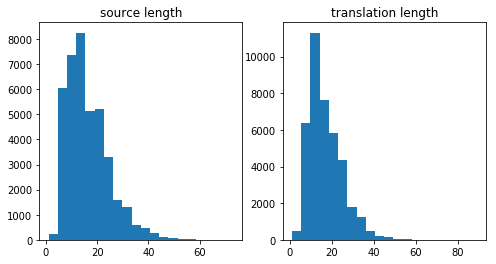

In [14]:
src_length = list(map(len, [x.src for x in train_data.examples]))
trg_length = list(map(len, [x.trg for x in train_data.examples]))

print('Length distribution in Train data')
print(f'Max source length: {max(src_length)}')
print(f'Max target length: {max(trg_length)}')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data
Max source length: 80
Max target length: 99


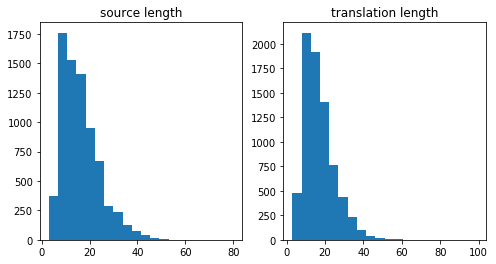

In [15]:
src_length = list(map(len, [x.src for x in test_data.examples]))
trg_length = list(map(len, [x.trg for x in test_data.examples]))

print('Length distribution in Test data')
print(f'Max source length: {max(src_length)}')
print(f'Max target length: {max(trg_length)}')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [16]:
device = torch.device(DEVICE_NAME if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [17]:
def eval_bleu(model, test_iterator, target_vocab=TRG.vocab, beam_width=1, with_tqdm=True):
    assert beam_width > 0
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():
        if with_tqdm:
            test_iterator = tqdm(test_iterator, position=0, leave=True)
        for i, batch in enumerate(test_iterator):
            src = batch.src # [src sent len, batch size]
            trg = batch.trg # [trg sent len, batch size]
            
            if beam_width == 1:
                output = model(src, trg, 0) #turn off teacher forcing
                #output = [trg sent len, batch size, output dim]

                output = output.argmax(dim=-1) # [trg sent len, batch size]
            else:
                output = beam_search(model, src, trg, target_vocab, beam_width)  # [trg sent len, batch size]

            original_text.extend([get_text(x, target_vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, target_vocab) for x in output[1:].detach().cpu().numpy().T])
    return corpus_bleu([[text] for text in original_text], generated_text) * 100

In [18]:
def get_teacher_forcing_ratio(epoch, base_teacher_forcing_ratio=0.5, decay=1):
    return base_teacher_forcing_ratio * decay ** epoch

In [19]:
def train(model, iterator, optimizer, criterion, clip, epoch):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):        
        src = batch.src # [src sent len, batch size]
        trg = batch.trg # [trg sent len, batch size]
        
        optimizer.zero_grad()        
        teacher_forcing_ratio = get_teacher_forcing_ratio(epoch)
        output = model(src, trg, teacher_forcing_ratio) # [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1]) # [(trg sent len - 1) * batch size, output dim]
        trg = trg[1:].view(-1) # [(trg sent len - 1) * batch size]
        
        loss = criterion(output, trg)        
        loss.backward()
        
        # Let's clip the gradient
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()        
        batch_loss = loss.item()
        epoch_loss += batch_loss
        
    return epoch_loss / len(iterator)

In [20]:
def evaluate(model, iterator, criterion):    
    model.eval()    
    epoch_loss = 0    
    with torch.no_grad():    
        for i, batch in enumerate(iterator):
            src = batch.src # [src sent len, batch size]
            trg = batch.trg # [trg sent len, batch size]

            output = model(src, trg, 0) #turn off teacher forcing
            # [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1]) # [(trg sent len - 1) * batch size]
            trg = trg[1:].view(-1) # [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
def training_procedure(model, model_name, train_iterator, valid_iterator,
                      optimizer, lr_scheduler, criterion, writer, clip, n_epochs, beam_width=10):
    best_valid_bleu = float('-inf')
    for epoch in tqdm(range(n_epochs)):    
        start_time = time.time()

        train_loss = train(model, train_iterator, optimizer, criterion, clip, epoch)
        valid_loss = evaluate(model, valid_iterator, criterion)
        lr_scheduler.step(valid_loss)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        valid_bleu_greedy = eval_bleu(model, valid_iterator, beam_width=1, with_tqdm=False)
        writer.add_scalar('Validation BLEU (Greedy)',
                    valid_bleu_greedy,
                    epoch)
        
        valid_bleu_beam = eval_bleu(model, valid_iterator, beam_width=beam_width, with_tqdm=False)
        writer.add_scalar(f'Validation BLEU (BeamSearch@{beam_width})',
                    valid_bleu_beam,
                    epoch)
        
        max_bleu = max(valid_bleu_greedy, valid_bleu_beam)
        if max_bleu > best_valid_bleu:
            best_valid_bleu = max_bleu
            torch.save(model.state_dict(), f'models/{model_name}.pt')

        writer.add_scalar('Train loss',
                    train_loss,
                    epoch)
        writer.add_scalar('Validation loss',
                    valid_loss,
                    epoch)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')
        print(f'\tVal. BLEU (Greedy): {valid_bleu_greedy:.3f} | Val. BLEU (BeamSearch@{beam_width}): {valid_bleu_beam:.3f}')

In [23]:
def get_tensorboard_dir(model_name):
    return f'runs/{model_name}'

In [24]:
def print_samples(model, test_iterator, indices=range(0, 10), beam_widths=[2,10]):
    batch = next(iter(test_iterator))
    for idx in indices:
        src = batch.src[:, idx:idx+1]
        trg = batch.trg[:, idx:idx+1]
        generate_translation(src, trg, model, TRG.vocab, beam_widths)

## Let's use GRU encoder-decoder with attention

In [25]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [26]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

LR = 1e-3
CLIP = 1
N_EPOCHS = 35

In [27]:
from models import GruEncoder, AttentionGruDecoder, AttentionGruSeq2Seq

enc = GruEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = AttentionGruDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = AttentionGruSeq2Seq(enc, dec, device).to(device)
model.apply(init_weights)

AttentionGruSeq2Seq(
  (encoder): GruEncoder(
    (embedding): Embedding(9256, 256)
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): AttentionGruDecoder(
    (embedding): Embedding(6734, 256)
    (attention): Attention(
      (linear_in): Linear(in_features=1024, out_features=1024, bias=False)
      (linear_out): Linear(in_features=2048, out_features=1024, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (rnn): GRU(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=1024, out_features=6734, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [28]:
count_parameters(model)

19658830

In [29]:
PAD_IDX = TRG.vocab.stoi['<pad>']

In [30]:
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.001, amsgrad=True)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=2)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [31]:
tensorboard_dir = get_tensorboard_dir(model_name)
print(tensorboard_dir)
writer = SummaryWriter(tensorboard_dir)
training_procedure(model, model_name, train_iterator, valid_iterator,
                      optimizer, lr_scheduler, criterion, writer, clip=CLIP, n_epochs=N_EPOCHS)

  0%|          | 0/35 [00:00<?, ?it/s]

runs/gru_attention_beam_search_2020-05-28--20-39-59


  3%|▎         | 1/35 [04:20<2:27:44, 260.73s/it]

Epoch: 01 | Time: 2m 12s
	Train Loss: 4.209 | Train PPL:  67.322
	 Val. Loss: 4.706 |  Val. PPL: 110.616
	Val. BLEU (Greedy): 17.175 | Val. BLEU (BeamSearch@10): 19.824


  6%|▌         | 2/35 [08:45<2:24:01, 261.85s/it]

Epoch: 02 | Time: 2m 11s
	Train Loss: 3.180 | Train PPL:  24.050
	 Val. Loss: 4.550 |  Val. PPL:  94.679
	Val. BLEU (Greedy): 24.819 | Val. BLEU (BeamSearch@10): 26.979


  9%|▊         | 3/35 [13:12<2:20:31, 263.49s/it]

Epoch: 03 | Time: 2m 13s
	Train Loss: 2.865 | Train PPL:  17.554
	 Val. Loss: 4.275 |  Val. PPL:  71.891
	Val. BLEU (Greedy): 26.980 | Val. BLEU (BeamSearch@10): 28.969


 11%|█▏        | 4/35 [17:37<2:16:23, 263.97s/it]

Epoch: 04 | Time: 2m 12s
	Train Loss: 2.631 | Train PPL:  13.888
	 Val. Loss: 4.433 |  Val. PPL:  84.147
	Val. BLEU (Greedy): 29.273 | Val. BLEU (BeamSearch@10): 31.513


 14%|█▍        | 5/35 [22:05<2:12:38, 265.29s/it]

Epoch: 05 | Time: 2m 14s
	Train Loss: 2.463 | Train PPL:  11.739
	 Val. Loss: 4.427 |  Val. PPL:  83.704
	Val. BLEU (Greedy): 30.453 | Val. BLEU (BeamSearch@10): 33.210


 17%|█▋        | 6/35 [26:34<2:08:44, 266.37s/it]

Epoch: 06 | Time: 2m 13s
	Train Loss: 2.343 | Train PPL:  10.418
	 Val. Loss: 4.279 |  Val. PPL:  72.166
	Val. BLEU (Greedy): 29.137 | Val. BLEU (BeamSearch@10): 31.796


 20%|██        | 7/35 [31:08<2:05:18, 268.52s/it]

Epoch: 07 | Time: 2m 11s
	Train Loss: 2.061 | Train PPL:   7.854
	 Val. Loss: 4.264 |  Val. PPL:  71.075
	Val. BLEU (Greedy): 33.149 | Val. BLEU (BeamSearch@10): 35.965


 23%|██▎       | 8/35 [35:42<2:01:37, 270.29s/it]

Epoch: 08 | Time: 2m 13s
	Train Loss: 1.940 | Train PPL:   6.959
	 Val. Loss: 4.347 |  Val. PPL:  77.250
	Val. BLEU (Greedy): 33.020 | Val. BLEU (BeamSearch@10): 36.027


 26%|██▌       | 9/35 [40:14<1:57:17, 270.67s/it]

Epoch: 09 | Time: 2m 12s
	Train Loss: 1.866 | Train PPL:   6.460
	 Val. Loss: 4.285 |  Val. PPL:  72.584
	Val. BLEU (Greedy): 33.365 | Val. BLEU (BeamSearch@10): 36.273


 29%|██▊       | 10/35 [44:50<1:53:25, 272.22s/it]

Epoch: 10 | Time: 2m 13s
	Train Loss: 1.838 | Train PPL:   6.284
	 Val. Loss: 4.330 |  Val. PPL:  75.955
	Val. BLEU (Greedy): 33.806 | Val. BLEU (BeamSearch@10): 36.415


 31%|███▏      | 11/35 [49:11<1:47:31, 268.82s/it]

Epoch: 11 | Time: 2m 13s
	Train Loss: 1.723 | Train PPL:   5.604
	 Val. Loss: 4.353 |  Val. PPL:  77.720
	Val. BLEU (Greedy): 34.288 | Val. BLEU (BeamSearch@10): 36.852


 34%|███▍      | 12/35 [53:37<1:42:43, 267.96s/it]

Epoch: 12 | Time: 2m 13s
	Train Loss: 1.712 | Train PPL:   5.540
	 Val. Loss: 4.370 |  Val. PPL:  79.006
	Val. BLEU (Greedy): 34.262 | Val. BLEU (BeamSearch@10): 36.906


 37%|███▋      | 13/35 [58:04<1:38:10, 267.77s/it]

Epoch: 13 | Time: 2m 11s
	Train Loss: 1.665 | Train PPL:   5.287
	 Val. Loss: 4.342 |  Val. PPL:  76.887
	Val. BLEU (Greedy): 34.387 | Val. BLEU (BeamSearch@10): 36.895


 40%|████      | 14/35 [1:02:42<1:34:47, 270.85s/it]

Epoch: 14 | Time: 2m 12s
	Train Loss: 1.659 | Train PPL:   5.253
	 Val. Loss: 4.372 |  Val. PPL:  79.191
	Val. BLEU (Greedy): 34.189 | Val. BLEU (BeamSearch@10): 36.976


 43%|████▎     | 15/35 [1:07:21<1:31:07, 273.36s/it]

Epoch: 15 | Time: 2m 15s
	Train Loss: 1.657 | Train PPL:   5.243
	 Val. Loss: 4.363 |  Val. PPL:  78.504
	Val. BLEU (Greedy): 34.315 | Val. BLEU (BeamSearch@10): 36.867


 46%|████▌     | 16/35 [1:11:55<1:26:37, 273.54s/it]

Epoch: 16 | Time: 2m 16s
	Train Loss: 1.640 | Train PPL:   5.157
	 Val. Loss: 4.391 |  Val. PPL:  80.690
	Val. BLEU (Greedy): 34.576 | Val. BLEU (BeamSearch@10): 36.836


 49%|████▊     | 17/35 [1:16:27<1:21:56, 273.14s/it]

Epoch: 17 | Time: 2m 16s
	Train Loss: 1.651 | Train PPL:   5.211
	 Val. Loss: 4.366 |  Val. PPL:  78.719
	Val. BLEU (Greedy): 34.539 | Val. BLEU (BeamSearch@10): 36.998


 51%|█████▏    | 18/35 [1:21:01<1:17:24, 273.21s/it]

Epoch: 18 | Time: 2m 12s
	Train Loss: 1.641 | Train PPL:   5.158
	 Val. Loss: 4.368 |  Val. PPL:  78.861
	Val. BLEU (Greedy): 34.524 | Val. BLEU (BeamSearch@10): 36.909


 54%|█████▍    | 19/35 [1:25:40<1:13:22, 275.17s/it]

Epoch: 19 | Time: 2m 16s
	Train Loss: 1.647 | Train PPL:   5.190
	 Val. Loss: 4.364 |  Val. PPL:  78.564
	Val. BLEU (Greedy): 34.485 | Val. BLEU (BeamSearch@10): 36.879


 57%|█████▋    | 20/35 [1:30:10<1:08:22, 273.52s/it]

Epoch: 20 | Time: 2m 12s
	Train Loss: 1.623 | Train PPL:   5.068
	 Val. Loss: 4.365 |  Val. PPL:  78.682
	Val. BLEU (Greedy): 34.564 | Val. BLEU (BeamSearch@10): 36.923


 60%|██████    | 21/35 [1:34:43<1:03:46, 273.30s/it]

Epoch: 21 | Time: 2m 15s
	Train Loss: 1.627 | Train PPL:   5.090
	 Val. Loss: 4.369 |  Val. PPL:  78.990
	Val. BLEU (Greedy): 34.637 | Val. BLEU (BeamSearch@10): 36.917


 63%|██████▎   | 22/35 [1:39:07<58:35, 270.40s/it]  

Epoch: 22 | Time: 2m 13s
	Train Loss: 1.655 | Train PPL:   5.232
	 Val. Loss: 4.360 |  Val. PPL:  78.285
	Val. BLEU (Greedy): 34.698 | Val. BLEU (BeamSearch@10): 36.892


 66%|██████▌   | 23/35 [1:43:30<53:40, 268.36s/it]

Epoch: 23 | Time: 2m 11s
	Train Loss: 1.614 | Train PPL:   5.021
	 Val. Loss: 4.365 |  Val. PPL:  78.662
	Val. BLEU (Greedy): 34.672 | Val. BLEU (BeamSearch@10): 36.983


 69%|██████▊   | 24/35 [1:47:58<49:09, 268.14s/it]

Epoch: 24 | Time: 2m 12s
	Train Loss: 1.631 | Train PPL:   5.111
	 Val. Loss: 4.363 |  Val. PPL:  78.466
	Val. BLEU (Greedy): 34.633 | Val. BLEU (BeamSearch@10): 37.000


 71%|███████▏  | 25/35 [1:52:19<44:21, 266.18s/it]

Epoch: 25 | Time: 2m 9s
	Train Loss: 1.641 | Train PPL:   5.161
	 Val. Loss: 4.365 |  Val. PPL:  78.674
	Val. BLEU (Greedy): 34.632 | Val. BLEU (BeamSearch@10): 36.992


 74%|███████▍  | 26/35 [1:56:54<40:19, 268.81s/it]

Epoch: 26 | Time: 2m 15s
	Train Loss: 1.667 | Train PPL:   5.297
	 Val. Loss: 4.363 |  Val. PPL:  78.490
	Val. BLEU (Greedy): 34.634 | Val. BLEU (BeamSearch@10): 36.974


 77%|███████▋  | 27/35 [2:01:22<35:47, 268.43s/it]

Epoch: 27 | Time: 2m 12s
	Train Loss: 1.619 | Train PPL:   5.046
	 Val. Loss: 4.364 |  Val. PPL:  78.573
	Val. BLEU (Greedy): 34.641 | Val. BLEU (BeamSearch@10): 36.993


 80%|████████  | 28/35 [2:05:59<31:36, 270.95s/it]

Epoch: 28 | Time: 2m 12s
	Train Loss: 1.630 | Train PPL:   5.105
	 Val. Loss: 4.365 |  Val. PPL:  78.624
	Val. BLEU (Greedy): 34.642 | Val. BLEU (BeamSearch@10): 36.980


 83%|████████▎ | 29/35 [2:10:34<27:12, 272.16s/it]

Epoch: 29 | Time: 2m 11s
	Train Loss: 1.627 | Train PPL:   5.087
	 Val. Loss: 4.364 |  Val. PPL:  78.568
	Val. BLEU (Greedy): 34.640 | Val. BLEU (BeamSearch@10): 36.978


 86%|████████▌ | 30/35 [2:14:54<22:23, 268.62s/it]

Epoch: 30 | Time: 2m 11s
	Train Loss: 1.633 | Train PPL:   5.120
	 Val. Loss: 4.365 |  Val. PPL:  78.672
	Val. BLEU (Greedy): 34.633 | Val. BLEU (BeamSearch@10): 37.021


 89%|████████▊ | 31/35 [2:19:18<17:49, 267.38s/it]

Epoch: 31 | Time: 2m 11s
	Train Loss: 1.653 | Train PPL:   5.220
	 Val. Loss: 4.365 |  Val. PPL:  78.665
	Val. BLEU (Greedy): 34.635 | Val. BLEU (BeamSearch@10): 37.012


 91%|█████████▏| 32/35 [2:23:48<13:23, 267.98s/it]

Epoch: 32 | Time: 2m 12s
	Train Loss: 1.653 | Train PPL:   5.223
	 Val. Loss: 4.365 |  Val. PPL:  78.671
	Val. BLEU (Greedy): 34.636 | Val. BLEU (BeamSearch@10): 37.042


 94%|█████████▍| 33/35 [2:28:08<08:51, 265.56s/it]

Epoch: 33 | Time: 2m 10s
	Train Loss: 1.617 | Train PPL:   5.038
	 Val. Loss: 4.365 |  Val. PPL:  78.633
	Val. BLEU (Greedy): 34.636 | Val. BLEU (BeamSearch@10): 37.034


 97%|█████████▋| 34/35 [2:32:36<04:26, 266.30s/it]

Epoch: 34 | Time: 2m 12s
	Train Loss: 1.640 | Train PPL:   5.154
	 Val. Loss: 4.365 |  Val. PPL:  78.684
	Val. BLEU (Greedy): 34.631 | Val. BLEU (BeamSearch@10): 37.053


100%|██████████| 35/35 [2:37:02<00:00, 266.18s/it]

Epoch: 35 | Time: 2m 10s
	Train Loss: 1.629 | Train PPL:   5.096
	 Val. Loss: 4.365 |  Val. PPL:  78.684
	Val. BLEU (Greedy): 34.631 | Val. BLEU (BeamSearch@10): 37.053


**Let's load best model**

In [32]:
with open(f'models/{model_name}.pt', 'rb') as fp:
    best_state_dict = torch.load(fp, map_location='cpu')
    model.load_state_dict(best_state_dict)

**And look at its predictions**

In [33]:
print_samples(model, test_iterator)

Original:                   there is a 24 - hour front desk at the property .
Generated (Greedy):         there is a 24 - hour front desk at the property .
Generated (BeamSearch@2):   there is a 24 - hour front desk at the property .
Generated (BeamSearch@10):  there is a 24 - hour front desk at the property .

Original:                   you will find a 24 - hour front desk at the property .
Generated (Greedy):         there is a 24 - hour front desk at the property .
Generated (BeamSearch@2):   there is a 24 - hour front desk at the property .
Generated (BeamSearch@10):  there is a 24 - hour front desk at the property .

Original:                   there is a 24 - hour front desk at the property .
Generated (Greedy):         there is a 24 - hour front desk at the property .
Generated (BeamSearch@2):   there is a 24 - hour front desk at the property .
Generated (BeamSearch@10):  there is a 24 - hour front desk at the property .

Original:                   free private parking is avai

In [34]:
print('Test BLEU (Greedy):', eval_bleu(model, test_iterator, beam_width=1))

100%|██████████| 59/59 [00:04<00:00,  6.39it/s]


Test BLEU (Greedy): 33.56373600982891


In [35]:
print('Test BLEU (BeamSearch@2):', eval_bleu(model, test_iterator, beam_width=2))

100%|██████████| 59/59 [05:48<00:00, 10.76s/it]


Test BLEU (BeamSearch@2): 35.28129472593689


In [36]:
print('Test BLEU (BeamSearch@5):', eval_bleu(model, test_iterator, beam_width=5))

100%|██████████| 59/59 [06:13<00:00, 11.41s/it]


Test BLEU (BeamSearch@5): 36.27547115971034


In [37]:
print('Test BLEU (BeamSearch@10):', eval_bleu(model, test_iterator, beam_width=10))

100%|██████████| 59/59 [06:48<00:00, 12.46s/it]


Test BLEU (BeamSearch@10): 36.458068335487575


In [38]:
print('Test BLEU (BeamSearch@16):', eval_bleu(model, test_iterator, beam_width=16))

100%|██████████| 59/59 [07:42<00:00, 13.77s/it]


Test BLEU (BeamSearch@16): 36.220588121598944


In [39]:
print('Test BLEU (BeamSearch@32):', eval_bleu(model, test_iterator, beam_width=32))

100%|██████████| 59/59 [08:56<00:00, 14.77s/it]


Test BLEU (BeamSearch@32): 34.08192936277189


**And plot train/val metrics**

In [40]:
logs = parse_tensorboard_logs(tensorboard_dir)

In [41]:
printable_model_name = '_'.join(model_name.split('_')[:-1])

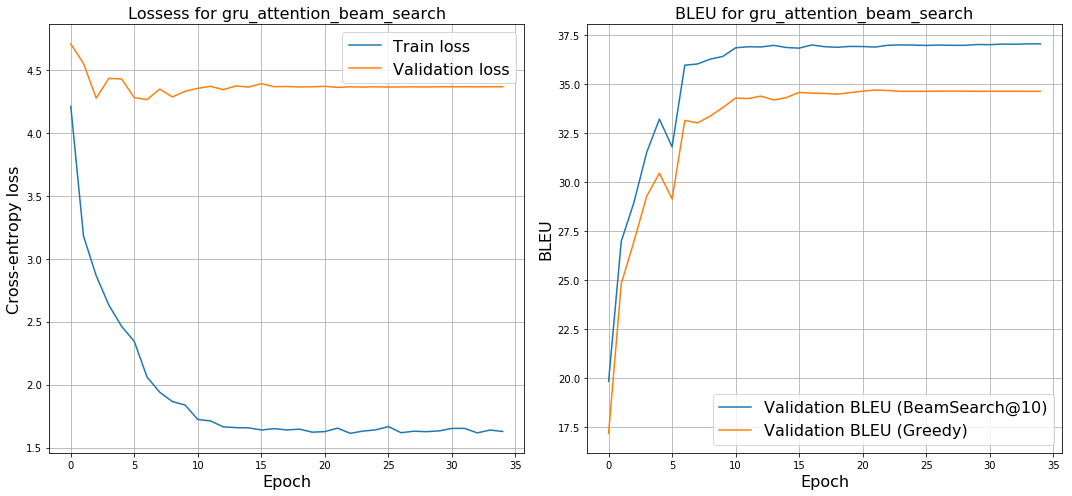

In [42]:
plot_metrics(logs, printable_model_name)